## Imports & Dataset

In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


Hyperparameters vs Model Parameters

Structural hyperparameters

* number of layers

* number of neurons

Optimization hyperparameters

* learning rate

* batch size

Regularization hyperparameters

* L1/L2

* dropout rate

| Category                       | Examples      |
| ------------------------------ | ------------- |
| Model Parameters               | Weights, bias |
| Structural Hyperparameters     | Layers, depth |
| Optimization Hyperparameters   | Learning rate |
| Regularization Hyperparameters | C, alpha      |


In [ ]:
# Load dataset
X, y = load_iris(return_X_y=True)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (120, 4)
Test shape: (30, 4)


## Why Hyperparameter Tuning?

In [ ]:
model = SVC()  # default hyperparameters

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-val accuracy (default SVC):", scores.mean())


Cross-val accuracy (default SVC): 0.95


**Explanation**

Default parameters are rarely optimal

Hyperparameters control model behavior, not learned weights

We tune them to improve generalization

***What does cv = 5 mean?***

Your training data is split into 5 equal parts (folds).

Then the model is trained and evaluated 5 times:

* Each time, 4 folds are used for training

* 1 different fold is used for validation

Every fold becomes the validation set once.

There are different types of Cross Validation Technique which are discussed at the end.

## What is Grid Search?

Grid Search tries ALL combinations of hyperparameters.

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

param_grid

# Total combinations = 3 × 2 = 6

in SVC, C is the regularization parameter.
It controls the trade-off between maximizing the margin and minimizing classification errors.

##  Hyperparameter Search Space Design (Very Important)

Choosing **what values to try** for hyperparameters is just as important as choosing
**Grid Search or Random Search**.

A badly designed search space can:
- Waste computation
- Miss the best model
- Give misleading results

---

##  Why Search Space Design Matters

Hyperparameters can affect the model **very differently**.

Example:
- Changing learning rate from `0.001 → 0.01`  
  (10× increase → BIG effect)
- Changing learning rate from `0.101 → 0.102`  
  (small effect)

Therefore, values should not always be equally spaced.

---

##  Linear Scale vs Log Scale

```text
Linear Scale
Values increase by a constant difference.

Example:

[1, 2, 3, 4, 5]

Used when:

The parameter has a direct, linear effect
Small changes have similar impact

Examples:

Tree depth
Number of neighbors (k in KNN)
Number of layers
```
```text
Logarithmic (Log) Scale

Values increase by a constant ratio (usually ×10).

Example:
[0.001, 0.01, 0.1, 1, 10]

Used when:

Parameter spans multiple orders of magnitude
Small values have very different effects than large values
```

## Discrete vs Continuous Hyperparameters

```text
Discrete Hyperparameters

Take specific integer or categorical values.

Examples:

Number of layers: 2, 3, 4
Max depth: 5, 10, 20
Kernel type: linear, rbf, poly

Example:
max_depth = [5, 10, 20]
```
```text
Continuous Hyperparameters

Can take any real value in a range.

Examples:

Learning rate
Regularization strength (C, alpha)
Dropout rate

Example:
C = [0.001, 0.01, 0.1, 1, 10]

next

C = [.005, 0.01, 0.05, 0.08]

```

## Choosing the Right Scale

| Hyperparameter            | Type       | Recommended Scale     |
| ------------------------- | ---------- | --------------------- |
| Learning rate             | Continuous | Log scale             |
| Regularization (C, alpha) | Continuous | Log scale             |
| Tree depth                | Discrete   | Linear                |
| Number of neighbors (KNN) | Discrete   | Linear                |
| Batch size                | Discrete   | Log-like (16, 32, 64) |


```text
Rule of Thumb

Use log scale for:

Learning rate
Regularization

Use linear scale for:

Counts, depths, sizes

Start coarse, then refine
First search wide, then search narrow.
```

`GridSearchCV` tests all combinations of hyperparameters using internal CV.
We'll tune SVC parameters:
- Regularization strength (`C`)
- Kernel(linear & rbf)

It will find the **best combination** that gives highest accuracy.

## GridSearchCV (with Cross-Validation)

In [ ]:
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,               # cross-validation INSIDE tuning
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

This means:

For EACH hyperparameter combination,
perform 5-fold cross-validation

***Example:***

6 hyperparameter combinations

cv = 5

Total model trainings = 6 × 5 = 30

**What does n_jobs = -1 mean?**

n_jobs = -1 means use ALL available CPU cores on your machine to run the computation in parallel.


When a task can be split into independent pieces (like cross-validation or grid search):

* n_jobs = 1 → use 1 CPU core (slow)

* n_jobs = 2 → use 2 CPU cores

* n_jobs = -1 → use all CPU cores

## Understanding GridSearchCV Output

In [ ]:
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best parameters: {'C': 1, 'kernel': 'linear'}
Best CV accuracy: 0.9583333333333334


In [ ]:
# Best model is already refit on full training data
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Test accuracy: 1.0


Key Concept

* Cross-validation happens inside GridSearch → NOT on test data
* Test set is used only once at the end

## Visualizing Grid Search Results

In [ ]:
results = pd.DataFrame(grid.cv_results_)
results[['param_C', 'param_kernel', 'mean_test_score']]  #actually mean_test_score are Avg score on validation folds

,param_C,param_kernel,mean_test_score
0,0.1,linear,0.941667
1,0.1,rbf,0.891667
2,1.0,linear,0.958333
3,1.0,rbf,0.950000
4,10.0,linear,0.950000
5,10.0,rbf,0.950000


## Random Search

* Random Search tries random combinations, not all.

### When to use Random Search?

* Large hyperparameter space

* Continuous values (learning rate, regularization)

* Faster than Grid Search

In [ ]:
param_dist = {
    'C': np.logspace(-3, 2, 20),
    'kernel': ['linear', 'rbf', 'poly']
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=10,          # Only 10 random hyperparameter combinations will be tried
    cv=5,     #For each random hyperparameter setting: Perform 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.83298071e-03, 3.35981829e-03, 6.15848211e-03,
       1.12883789e-02, 2.06913808e-02, 3.79269019e-02, 6.95192796e-02,
       1.27427499e-01, 2.33572147e-01, 4.28133240e-01, 7.84759970e-01,
       1.43844989e+00, 2.63665090e+00, 4.83293024e+00, 8.85866790e+00,
       1.62377674e+01, 2.97635144e+01, 5.45559478e+01, 1.00000000e+02]),
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='accuracy')

## Random Search Results

In [ ]:
print("Best parameters (Random Search):", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

Best parameters (Random Search): {'kernel': 'linear', 'C': np.float64(0.7847599703514607)}
Best CV accuracy: 0.9666666666666666


## Grid Search vs Random Search

In [ ]:
summary = pd.DataFrame({
    "Method": ["Grid Search", "Random Search"],
    "Best CV Accuracy": [
        grid.best_score_,
        random_search.best_score_
    ]
})

summary

,Method,Best CV Accuracy
0,Grid Search,0.958333
1,Random Search,0.966667


Random search can outperform grid search because it explores the hyperparameter space more effectively, especially when only a few hyperparameters truly matter.

## Conceptual Comparison

| Aspect                 | Grid Search   | Random Search       |
| ---------------------- | ------------- | ------------------- |
| Search type            | Exhaustive    | Random              |
| Speed                  | Slow          | Faster              |
| Best for               | Small spaces  | Large spaces        |
| Guarantees best combo? | Yes (in grid) | No (but often good) |


## Nested CV with SVM (Classification Example)

Nested cross-validation uses an inner loop to tune hyperparameters and an outer loop to evaluate generalization performance, ensuring an unbiased estimate of model accuracy.

In [ ]:
model = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}


### Inner Loop – Hyperparameter Tuning

In [ ]:
inner_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,            # INNER cross-validation
    scoring='accuracy',
    n_jobs=-1
)


In inner loop, validation folds directly influence which model is chosen

### Outer Loop – Model Evaluation

In [ ]:
outer_scores = cross_val_score(
    estimator=inner_cv,
    X=X,
    y=y,
    cv=5,            # OUTER cross-validation
    scoring='accuracy',
    n_jobs=-1
)


In [ ]:
print("Nested CV accuracy scores:", outer_scores)
print("Mean Nested CV accuracy:", np.mean(outer_scores))
print("Std deviation:", np.std(outer_scores))


 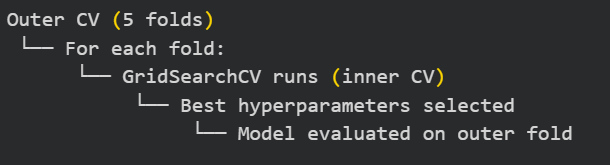


Entire Dataset (X, y)
 ├─ Outer Fold 1
 │   ├─ Inner CV (tuning)
 │   └─ Test (evaluation)
 ├─ Outer Fold 2
 │   ├─ Inner CV (tuning)
 │   └─ Test (evaluation)
 ...


Hyperparameters are selected WITHOUT seeing the outer test fold

Gives unbiased performance estimate

### When to Use Nested CV

Small datasets

Research papers

Fair model comparison

```text
 Usually NOT needed for everyday projects
 ```




## Different types of Cross Validation

In [ ]:
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
#  Load Classification Dataset

data = load_iris()
X = data.data # Features from Iris dataset
y = data.target # Target from Iris dataset (discrete labels)

print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y)))

Dataset shape: (150, 4)
Number of classes: 3


In [ ]:
#  HOLD-OUT VALIDATION (Train/Test Split)

print("--- Hold-Out Validation ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])
print("Accuracy (Hold-out):", accuracy_score(y_test, y_pred))

--- Hold-Out Validation ---
Train size: 105 | Test size: 45
Accuracy (Hold-out): 0.9333333333333333


We split data into:
- 70% training
- 30% testing

Then train a **Logistic Regression** model and check test accuracy.
This is the simplest form of validation.

In [ ]:
#  K-FOLD CROSS VALIDATION
print("--- K-Fold Cross Validation ---")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)
print("K-Fold scores:", scores)
print("Mean accuracy:", np.mean(scores))

--- K-Fold Cross Validation ---
K-Fold scores: [1.         1.         0.93333333 0.96666667 0.96666667]
Mean accuracy: 0.9733333333333334


We divide data into **K=5 folds**.
Each fold gets a turn as test data while the rest are used for training.
We average the accuracy scores across folds.

This reduces bias due to a single train/test split.

In [ ]:
#  STRATIFIED K-FOLD (Preserves Class Ratio)

print("--- Stratified K-Fold Cross Validation ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_strat = cross_val_score(model, X, y, cv=skf)
print("Stratified K-Fold scores:", scores_strat)
print("Mean accuracy:", np.mean(scores_strat))

--- Stratified K-Fold Cross Validation ---
Stratified K-Fold scores: [1.         0.96666667 0.93333333 1.         0.93333333]
Mean accuracy: 0.9666666666666668


Similar to K-Fold but ensures **each fold has the same class ratio** as the full dataset.
Useful for **classification problems** with imbalanced class distributions.

In [ ]:
#  LEAVE-ONE-OUT CROSS VALIDATION (LOOCV)
print("--- Leave-One-Out Cross Validation ---")

loo = LeaveOneOut()
scores_loo = cross_val_score(model, X, y, cv=loo)
print("Number of splits (LOOCV):", loo.get_n_splits(X))
print("Mean accuracy (LOOCV):", np.mean(scores_loo))


Here, **each sample acts as a test set once** and model trains on remaining samples.
This is the most exhaustive form of cross-validation but computationally expensive.

It will test equal to no of data sample times i.e. 150

## Activity

### Classify Hyperparameter vs Model Parameter

learning_rate

weights

C (SVM)

bias

number_of_layers

kernel


Hyperparameters: learning_rate, C, number_of_layers, kernel

Model parameters: weights, bias

**Hyperparameters are set before training, parameters are learned during training**

### Predict the Best Hyperparameter

| C   | Kernel | CV Accuracy |
| --- | ------ | ----------- |
| 0.1 | linear | 0.88        |
| 0.1 | rbf    | 0.90        |
| 1   | linear | 0.91        |
| 1   | rbf    | 0.95        |

Which combination will GridSearchCV select?

Why not retrain again on test data?

GridSearchCV selects highest CV score

Test set must remain untouched

### Run & Modify GridSearchCV

param_grid = {

    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

Task:

* Remove one value of C

* Add 'poly' kernel

* Re-run GridSearchCV

Observe:

* Best parameters

* Best score


More combinations ≠ always better

Search space design matters

### Grid Search vs Random Search

You have:

* 10 hyperparameters
* Each has 10 possible values

Can Grid Search work here?

Which method is better?

Why?

Grid Search = $ 10¹⁰ $   combinations , not feasible.

GridSearchCV systematically evaluates all hyperparameter combinations using cross-validation and selects the best performing model.

Random Search = feasible

Random Search wins when resources are limited